In [1]:
clean_up = True
%run stdPackages.ipynb
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])

The file _gams_py_gdb2.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.


# Production

## 1. Data/settings

Load data, settings:

In [2]:
t = 2018
name = 'm'
module = name+'_P' # name of module
db_IO = GpyDB(pickle_path = os.path.join(d['data'], f'{name}_{t}')) # load IO database named IO_name
with open(f"{d['data']}\\glob_{t}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)

Add time index to the IO data:

In [3]:
def addT(symbol, t):
    return adjMultiIndex.bc(symbol, t).reorder_levels(['t']+symbol.index.names if 't' not in symbol.index.names else symbol.index.names)
[db_IO.__setitem__(k, addT(db_IO.get(k), glob.db['t'].vals)) for k in db_IO.getTypes(['variable','scalar_variable'])];

Make a copy for later:

In [4]:
db_IO0 = db_IO.copy() # we are going to adjust data along the way; this keeps a copy of the original data

Add durable prices (for now, to solve static calibration):

In [5]:
db_IO['pD'] = db_IO.get('pD_dur').combine_first(db_IO.get('pD'))
db_IO['p'] = db_IO.get('pD_dur').groupby(['t','n']).mean().combine_first(db_IO.get('p'))

## 2. Initial values

Set up nesting tree using the nesting structure:

In [6]:
tree = nestingTree.tree(name = f'{module}_ces', tree = db_IO.get('nestProduction').to_list()) # individual tree
Tree = nestingTree.aggTree(name = module, trees = {tree.name: tree})(namespace = {str(n)+'_input': n for n in db_IO.get('n')})

Initialize production module, without any durables at first:

In [7]:
P = mProduction.Production(tree=Tree, glob = glob) # initialize module from nesting tree and global settings
aggregateDB.subset_db(db_IO, Tree.db.get('s')) # goes through all symbols in db_IO and only keep the elements that are in the set 's' from Tree.db
aggregateDB.subset_db(db_IO, Tree.get('n')) # goes through all symbols in db_IO and only keep the elements that are in the set 'n' from Tree.db
robust.robust_merge_dbs(P.s.db, db_IO, priority = 'second') # Merge IO data into the database of the module; if a symbol is in both, prioritize records from the second database

Add value shares:

In [8]:
v = valueShares.valueShares(Tree, db_IO.copy())
v.compile() # set up model structure, and make sure to initialize symbols if they are not yet defined in the database 
v.write(); # write GAMS code used for the model
m = v.run(exportTo = d['work'],ws=ws) # solve the "model".

Use value shares to initialize variables:
* Outputs and inputs are provided by IO data.
* For intermediate goods, assume a price of 1 (default option in the class, so we don't have to do anything) and set value share = quantity.
* Set share parameters to the ones identified by value share system.

In [9]:
gpyDB.GpyDBs_AOM_Second(P.s.db, gpy(adj.rc_pd(m.out_db.get('vD'), P.get('int')).rename('qD'))) # set intermediate goods levels
gpyDB.GpyDBs_AOM_Second(P.s.db, gpy(m.out_db.get('mu').xs(P.get('t0')[0]).rename('mu'))) # set intermediate goods levels

Set tax rate to fit revenue collected in baseline year:

In [10]:
# P.s.db['tauLump'] = db_IO.get('TotalTax').rename('tauLump')
P.s.db['tauS'] = adjMultiIndex.applyMult(db_IO.get('TotalTax'), P.get('output')) / P.get('qS')

### 3. Static calibration

In [11]:
P.compile(initDB=True) # set up model structure, and make sure to initialize symbols if they are not yet defined in the database (initDB = True)
P.s.setstate('C') # set to calibration state
P.write(); # write GAMS code
mStatic = P.run(exportTo = d['work'],ws=ws,**{'cns': 'CONOPT4'}) # solve the model using CONOPT4.

### 4. Dynamic calibration

Initialize module with static calibration as data:

In [12]:
P = mProduction.Production_ExoMu(tree = Tree, glob = glob)
robust.robust_merge_dbs(P.s.db, mStatic.out_db.getTypes(['variable','scalar_variable']), priority = 'second')

Add durables:

In [13]:
aggregateDB.readSets(P.s.db) # this makes sure that all necessary sets are defined in the database

In [14]:
P.addDurables(dur = db_IO0.get('dur_p'), dur2inv = db_IO0.get('dur2inv'), f = 'sqrAdjCosts')
P.initDurables() # adjust to steady state-like model
P.compile(initDB=True) # set up model structure
P.write(); # write GAMS code
# mBaseline = P.run(exportTo = d['work'],ws=ws,**{'cns': 'CONOPT4'}) # solve the model using CONOPT4; baselinea

Solve dynamic calibration:

In [15]:
aggregateDB.subset_db(db_IO0, P.get('t0')) # Only keep IO data on baseline year
mCalib, cp = P.sneakyCalib(db_IO0, exportTo = d['work'],ws=ws, loop_kwargs = {'n': 10}, **{'cns': 'CONOPT4'})

### 5. Export 

In [16]:
robust.robust_merge_dbs(P.s.db, mCalib.out_db.getTypes(['variable','scalar_variable']), priority = 'second')
P.s.setstate('B')

Look at durables:

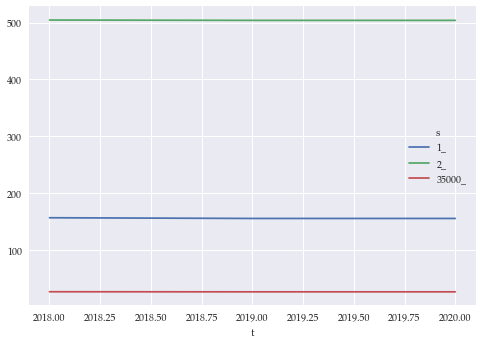

In [17]:
adj.rc_pd(P.get('qD'), P.get('dur')).groupby(['t','s']).sum().unstack('s').plot();

Export:

In [18]:
with open(os.path.join(d['data'], P.name), "wb") as file:
    pickle.dump(P,file)